## 模型优化

In [1]:
from keras.applications import *
from keras.preprocessing import image
from keras.layers import Dense, Dropout, Add, Maximum, Average,Concatenate
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint  
from keras import Input
from sklearn.utils import shuffle
import pandas as pd
import h5py
import numpy as np

/home/kevin/Documents/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/kevin/Documents/anaconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def load_gap_feature(model_name):
    with h5py.File('gap_{}.h5'.format(model_name),'r') as h:
        x_train = np.array(h['train'])
        y_train = np.array(h['label_train'])
        x_test = np.array(h['test'])
    return [x_train, y_train, x_test]

In [3]:
# 224x224
densenet_feature = load_gap_feature('densenet') #output:1664
resnet50_feature = load_gap_feature('resnet50') #output:2048
vgg16_feature = load_gap_feature('vgg16') #output:512
# 299x299
inception_feature = load_gap_feature('inception') #output:2048
increstnet_feature = load_gap_feature('inception_resnet') #output:1536
xception_feature = load_gap_feature('xception') #2048

In [4]:
# 打乱顺序
resnet50_feature[0],inception_feature[0],xception_feature[0],densenet_feature[0],vgg16_feature[0],increstnet_feature[0],densenet_feature[1] = shuffle(resnet50_feature[0],inception_feature[0],xception_feature[0],densenet_feature[0],vgg16_feature[0],increstnet_feature[0], densenet_feature[1])

In [5]:
def generate_test_prediction(pred, filename):
    df = pd.read_csv('prediction/sample_submission.csv')
    datagen = image.ImageDataGenerator()
    test_generator = datagen.flow_from_directory(
                'data/test',
                target_size=(224,224),
                batch_size=50,
                shuffle=False,
                class_mode=None)

    for i,path in enumerate(test_generator.filenames):
        index = int(path[path.rfind('/')+1:path.rfind('.')])
        df.set_value(index-1,'label',pred[i])

    df.to_csv('./prediction/{}.csv'.format(filename),index=False)

In [19]:
# 模型融合
input_tensor1 = Input(shape=(2048,))
input_tensor2 = Input(shape=(2048,))
input_tensor3 = Input(shape=(2048,))
input_tensor4 = Input(shape=(1664,))
input_tensor5 = Input(shape=(512,))
input_tensor6 = Input(shape=(1536,))
x = Concatenate(axis=1)([input_tensor1,input_tensor2,input_tensor3,input_tensor4,input_tensor5,input_tensor6])
x = Dropout(0.5)(x)
x = Dense(128,activation='relu')(x)
prediction = Dense(1,activation='sigmoid')(x)

model = Model([input_tensor1,input_tensor2,input_tensor3,input_tensor4,input_tensor5,input_tensor6], prediction)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

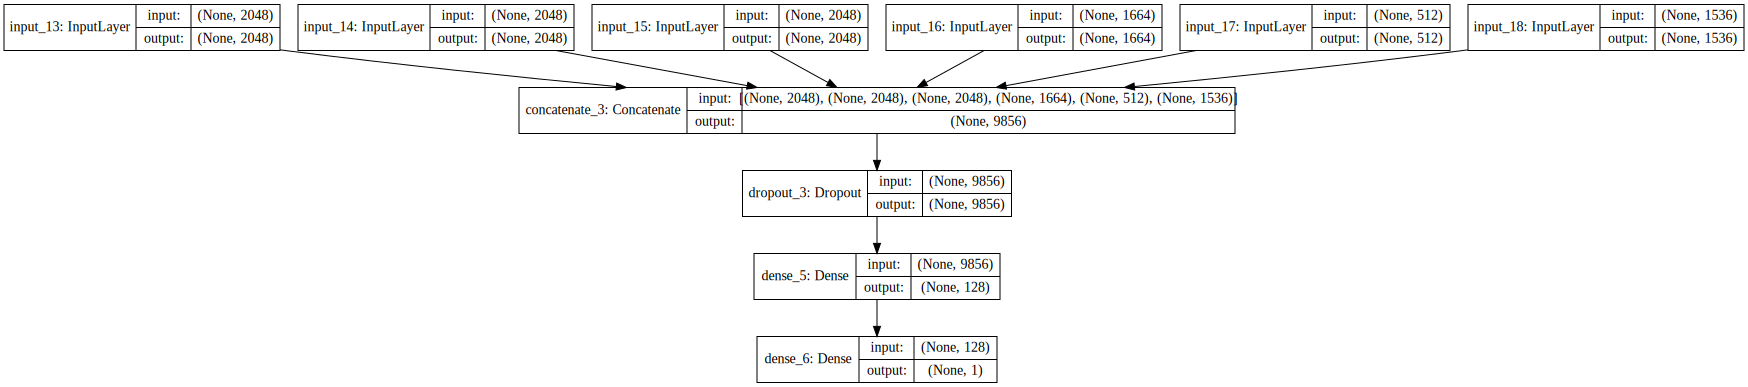

In [14]:
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, to_file='model.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [21]:
checkpointer = ModelCheckpoint(filepath='./saved_models/weights.best.comb6_model2.hdf5', 
                               verbose=1, save_best_only=True)


history = model.fit([resnet50_feature[0],inception_feature[0],xception_feature[0],densenet_feature[0],vgg16_feature[0],increstnet_feature[0]],
          densenet_feature[1], epochs=20,batch_size=50, verbose=1, callbacks=[checkpointer], validation_split=0.2)

Train on 25845 samples, validate on 6462 samples
Epoch 1/20
25845/25845 [==============================] - 5s 185us/step - loss: 0.0362 - acc: 0.9899 - val_loss: 0.0228 - val_acc: 0.9930

Epoch 00001: val_loss improved from inf to 0.02279, saving model to ./saved_models/weights.best.comb6_model2.hdf5
Epoch 2/20
25845/25845 [==============================] - 5s 177us/step - loss: 0.0144 - acc: 0.9956 - val_loss: 0.0131 - val_acc: 0.9960

Epoch 00002: val_loss improved from 0.02279 to 0.01315, saving model to ./saved_models/weights.best.comb6_model2.hdf5
Epoch 3/20
25845/25845 [==============================] - 4s 173us/step - loss: 0.0101 - acc: 0.9966 - val_loss: 0.0166 - val_acc: 0.9947

Epoch 00003: val_loss did not improve
Epoch 4/20
25845/25845 [==============================] - 4s 172us/step - loss: 0.0073 - acc: 0.9977 - val_loss: 0.0087 - val_acc: 0.9969

Epoch 00004: val_loss improved from 0.01315 to 0.00871, saving model to ./saved_models/weights.best.comb6_model2.hdf5
Epoch 5

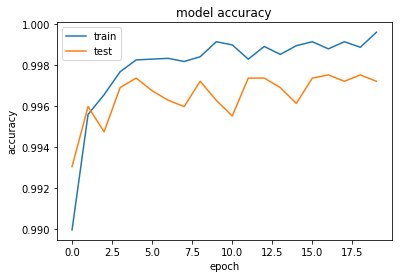

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

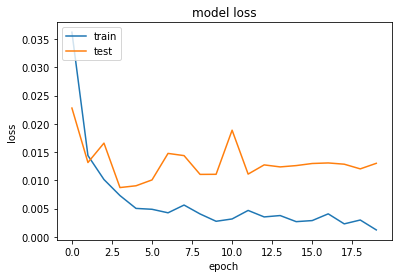

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
model.load_weights(filepath='./saved_models/weights.best.comb6_model2.hdf5')

model_pred = model.predict([resnet50_feature[2],inception_feature[2],xception_feature[2],densenet_feature[2],vgg16_feature[2],increstnet_feature[2]])

pred = model_pred.clip(0.005,0.995)

generate_test_prediction(pred, 'model2_comb6')

Found 12500 images belonging to 1 classes.


/home/kevin/Documents/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
